# Politiche economiche per combattere l'inflazione in Europa

https://github.com/Francois-Geerolf/EE2024-inflation/tree/master?tab=readme-ov-file

![|300](https://github.com/Francois-Geerolf/EE2024-inflation/raw/master/graphique1.png)

In [2]:
import pandas as pd
from eurostat import get_data_df
from plotnine import *
from datetime import datetime

In [5]:
# Carica i dati
df_manr_wide = get_data_df("prc_hicp_manr")

# Rinomina correttamente la colonna 'geo\\TIME_PERIOD' in 'geo'
df_manr_wide = df_manr_wide.rename(columns={"geo\\TIME_PERIOD": "geo"})

# Trasforma da wide a long: tutte le colonne da '1997-01' in poi diventano righe
df_manr_long = df_manr_wide.melt(
    id_vars=["freq", "unit", "coicop", "geo"],
    var_name="date",
    value_name="values"
)

# Converte la colonna 'date' in datetime
df_manr_long["date"] = pd.to_datetime(df_manr_long["date"], format="%Y-%m", errors="coerce")

# Opzionale: rimuove righe con valori mancanti
df_manr_long = df_manr_long.dropna(subset=["values"])

# Risultato
print(df_manr_long.head())

    freq   unit coicop geo       date  values
204    M  RCH_A   CP00  AT 1997-01-01     1.2
205    M  RCH_A   CP00  BE 1997-01-01     2.1
208    M  RCH_A   CP00  CY 1997-01-01     2.0
209    M  RCH_A   CP00  CZ 1997-01-01     7.2
210    M  RCH_A   CP00  DE 1997-01-01     1.9


In [6]:
df_ctrb_wide = get_data_df("prc_hicp_ctrb")
df_ctrb_wide = df_ctrb_wide.rename(columns={"geo\\TIME_PERIOD": "geo"})

df_ctrb_long = df_ctrb_wide.melt(
    id_vars=["freq", "unit", "coicop", "geo"],
    var_name="date",
    value_name="values"
)
df_ctrb_long["date"] = pd.to_datetime(df_ctrb_long["date"], format="%Y-%m", errors="coerce")
df_ctrb_long = df_ctrb_long.dropna(subset=["values"])


In [7]:
graphique1_line = (
    df_manr_long.query("coicop == 'CP00' and geo == 'EA'")
    .query("date >= '2021-03-01' and date <= '2023-04-01'")
)

# Contributo dei servizi e beni non energetici
sub = (
    df_ctrb_long.query("coicop in ['SERV', 'IGD_NNRG'] and geo == 'EA'")
    .query("date >= '2021-03-01' and date <= '2023-04-01'")
    .groupby(['date', 'unit', 'geo'], as_index=False)
    .agg({'values': 'sum'})
)
sub["coicop"] = "TOT_X_NRG_FOOD"

# Combina le due serie
graphique1_line = pd.concat([graphique1_line, sub], ignore_index=True)

# Etichette leggibili
graphique1_line["Line"] = pd.Categorical(
    graphique1_line["coicop"].replace({
        "CP00": "Inflation (HICP)",
        "TOT_X_NRG_FOOD": "Inflation sans énergie et alimentation"
    }),
    categories=["Inflation (HICP)", "Inflation sans énergie et alimentation"],
    ordered=True
)

graphique1_line = graphique1_line[["date", "Line", "values"]]


In [8]:
graphique1 = (
    df_ctrb_long.query("coicop in ['FOOD', 'NRG', 'IGD_NNRG', 'SERV'] and geo == 'EA'")
    .query("date >= '2021-03-01' and date <= '2023-04-01'")
    .copy()
)

coicop_map = {
    "SERV": "Services",
    "IGD_NNRG": "Biens manufacturés",
    "FOOD": "Alimentation",
    "NRG": "Energie"
}

graphique1["Coicop_factor"] = graphique1["coicop"].map(coicop_map)


In [9]:
from plotnine import *

plot = (
    ggplot(graphique1, aes(x="date", y="values/100"))
    + geom_col(aes(fill="Coicop_factor"), alpha=1)
    + geom_line(graphique1_line, aes(x="date", y="values/100", linetype="Line"), size=1.2)
    + scale_fill_manual(values=["#440154", "#21918c", "#fde725", "#5ec962"])
    + scale_x_datetime(date_labels="%b %Y", date_breaks="2 months")
    + scale_y_continuous(breaks=[x / 100 for x in range(-10, 31)],
                         labels=lambda l: [f"{int(100 * x)}%" for x in l])
    + theme_minimal()
    + labs(y="Contributions à l'inflation en zone Euro", x="")
    + theme(
        legend_position=(0.2, 0.77),
        axis_text_x=element_text(angle=45, ha="right"),
        legend_title=element_blank(),
        legend_key_size=8
    )
)

plot.save("graphique1.png", width=7, height=4, units="in")


c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:630: PlotnineWarning: Saving 7 x 4 in image.
c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\ggplot.py:631: PlotnineWarning: Filename: graphique1.png
c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\plotnine\scales\scale_linetype.py:45: PlotnineWarning: Using linetype for an ordinal variable is not advised.


In [10]:
import webbrowser
webbrowser.open("graphique1.png")


True

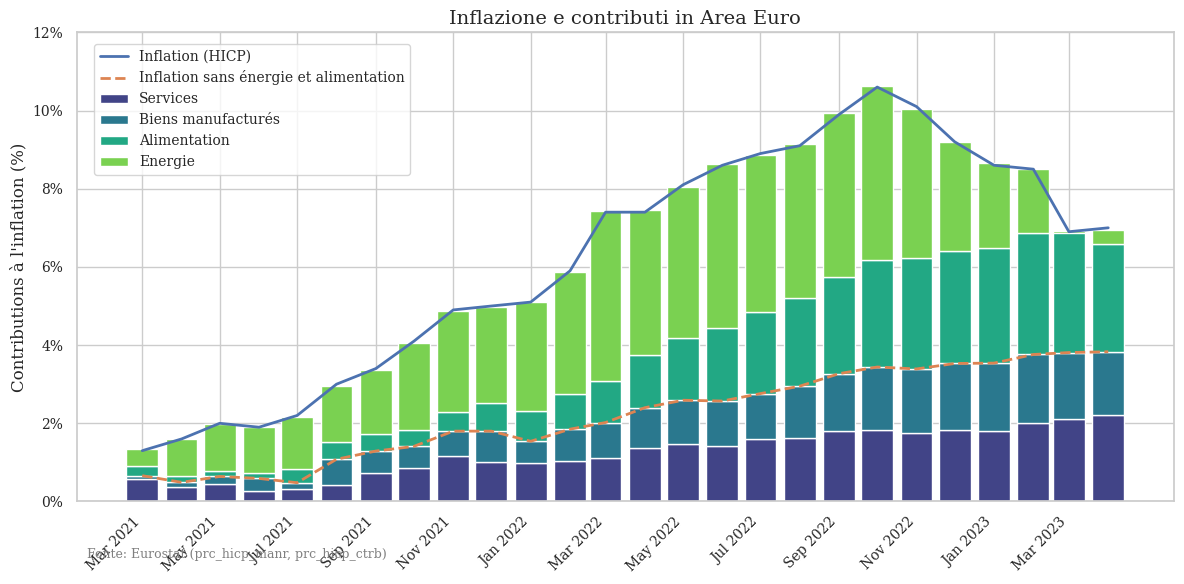

In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Dati già preparati
# pivot_df: index = date, columns = Services, Biens manufacturés, Alimentation, Energie (in %)
# graphique1_line: contiene le due linee (HICP e Core)

# Stile generale
sns.set(style="whitegrid")
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 14,
    "axes.labelsize": 12,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "legend.fontsize": 10,
    "font.family": "serif"
})

# Ordine e colori
coicop_order = ["Services", "Biens manufacturés", "Alimentation", "Energie"]
colors = sns.color_palette("viridis", n_colors=4)

# Inizializza figura
fig, ax = plt.subplots()

# Stack manuale delle barre
bottom = pd.Series(0, index=pivot_df.index)
for i, label in enumerate(coicop_order):
    heights = pivot_df[label]
    ax.bar(pivot_df.index, heights, bottom=bottom, label=label, color=colors[i], width=25)
    bottom += heights

# Linee sovrapposte
for label, linestyle in [("Inflation (HICP)", "solid"), ("Inflation sans énergie et alimentation", "dashed")]:
    subset = graphique1_line[graphique1_line["Line"] == label].sort_values("date")
    ax.plot(subset["date"], subset["values"] / 100, label=label, linestyle=linestyle, linewidth=2)

# Asse X
ax.set_xticks(pivot_df.index[::2])
ax.set_xticklabels([d.strftime("%b %Y") for d in pivot_df.index[::2]], rotation=45, ha="right")

# Asse Y
ax.set_ylim(0, 0.12)
ax.set_ylabel("Contributions à l'inflation (%)")
ax.set_yticks([i/100 for i in range(0, 13, 2)])
ax.set_yticklabels([f"{i}%" for i in range(0, 13, 2)])

# Legenda
ax.legend(loc="upper left", bbox_to_anchor=(0.01, 0.99))

# Titolo e fonte
ax.set_title("Inflazione e contributi in Area Euro")
ax.text(0.01, -0.12, "Fonte: Eurostat (prc_hicp_manr, prc_hicp_ctrb)", transform=ax.transAxes, fontsize=9, color="gray")

# Layout
plt.tight_layout()
plt.show()


In [13]:
print(pivot_df.shape)
print(pivot_df.head())


(26, 4)
Coicop_factor  Services  Biens manufacturés  Alimentation  Energie
date                                                              
2021-03-01       0.0057              0.0009        0.0024   0.0043
2021-04-01       0.0037              0.0012        0.0016   0.0096
2021-05-01       0.0045              0.0019        0.0015   0.0119
2021-06-01       0.0028              0.0031        0.0015   0.0116
2021-07-01       0.0031              0.0017        0.0035   0.0134


C:\Users\paolo\AppData\Local\Temp\ipykernel_25684\1772443060.py:65: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Georgia.
c:\Users\paolo\AppData\Local\Programs\Python\Python311\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 8594 (\N{RIGHTWARDS ARROW}) missing from font(s) Georgia.


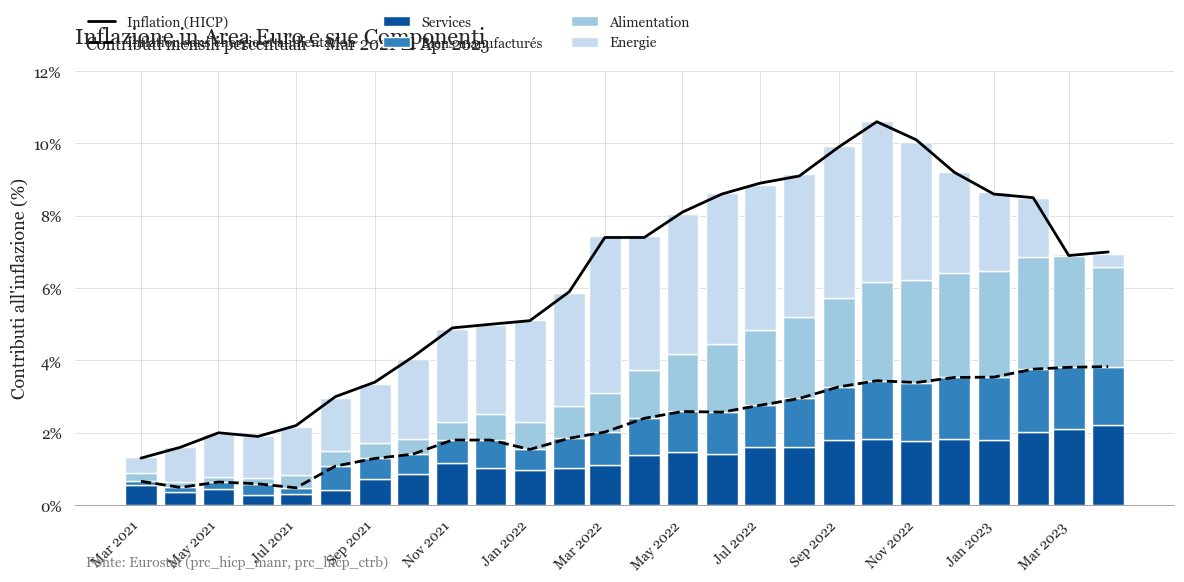

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Stile WSJ
plt.rcParams.update({
    "figure.figsize": (12, 6),
    "axes.titlesize": 16,
    "axes.labelsize": 13,
    "xtick.labelsize": 10,
    "ytick.labelsize": 11,
    "legend.fontsize": 10,
    "font.family": "serif",
    "font.serif": "Georgia",
    "axes.edgecolor": "gray",
    "axes.linewidth": 0.5,
    "axes.spines.top": False,
    "axes.spines.right": False,
    "axes.spines.left": False,
    "axes.grid": True,
    "grid.linestyle": "-",
    "grid.linewidth": 0.4,
    "grid.color": "#cccccc"
})

# Ordine e colori sobri (WSJ style)
coicop_order = ["Services", "Biens manufacturés", "Alimentation", "Energie"]
colors = ["#08519c", "#3182bd", "#9ecae1", "#c6dbef"]  # blu-grigi WSJ

# Costruzione del grafico
fig, ax = plt.subplots()

# Barre impilate
bottom = pd.Series(0, index=pivot_df.index)
for i, label in enumerate(coicop_order):
    ax.bar(pivot_df.index, pivot_df[label], bottom=bottom, label=label, color=colors[i], width=25)
    bottom += pivot_df[label]

# Linee HICP e core
for label, linestyle in [("Inflation (HICP)", "solid"), ("Inflation sans énergie et alimentation", "dashed")]:
    line_data = graphique1_line[graphique1_line["Line"] == label].sort_values("date")
    ax.plot(line_data["date"], line_data["values"] / 100, label=label, linestyle=linestyle, linewidth=2, color="black")

# Etichette asse X
ax.set_xticks(pivot_df.index[::2])
ax.set_xticklabels([d.strftime("%b %Y") for d in pivot_df.index[::2]], rotation=45, ha="right")

# Asse Y
ax.set_ylim(0, 0.12)
ax.set_ylabel("Contributi all'inflazione (%)")
ax.set_yticks([i / 100 for i in range(0, 13, 2)])
ax.set_yticklabels([f"{i}%" for i in range(0, 13, 2)])

# Titolo, sottotitolo, fonte
ax.set_title("Inflazione in Area Euro e sue Componenti", loc="left", pad=20)
ax.text(0.01, 1.05, "Contributi mensili percentuali – Mar 2021 → Apr 2023",
        transform=ax.transAxes, fontsize=12)
ax.text(0.01, -0.14, "Fonte: Eurostat (prc_hicp_manr, prc_hicp_ctrb)",
        transform=ax.transAxes, fontsize=10, color="gray")

# Legenda ordinata
ax.legend(loc="lower left", bbox_to_anchor=(0, 1.02), ncol=3, frameon=False)

# Layout finale
plt.tight_layout()

# Mostra il grafico
plt.show()
